In [1]:
import networkx as nx
import numpy as np
import pandas as pd 
import operator
import matplotlib.pyplot as plt
import random

In [2]:
nx_graphs = []
agg_graph = nx.MultiGraph()
venue_df_list = []
for i in range(31):
    # with open(f'..\ATX_Networks\sim_day_{i+1}.gexf') as graph_file:
    nx_graphs.append(nx.read_gexf(f'..\ATX_Networks\sim_day_{i+1}.gexf'))
    df = nx.to_pandas_edgelist(nx_graphs[i],source="Source",target="Target")
    df['day'] = i
    venue_df_list.append(df)

concat_venue_df = pd.concat(venue_df_list)
# concat_venue_df.columns = ['source','target','venueid']
concat_venue_df.head()


,Source,Target,id,hour,visits,time_spent,venueid,day
0,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,d531979041494d0d0d2387cfc611f6e70d91bcb92cf966...,0,2,18,976,440da2cbf964a52091301fe3,0
1,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,cf4e564f4c8e3aecc9dacafce90cada3eabaff58464e74...,1,2,2,100,440da2cbf964a52091301fe3,0
2,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,594a39e074fda9219102eff386f3da1944494aaa18c036...,2,4,2,14,440da2cbf964a52091301fe3,0
3,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,a1470e73f1bc4f7c757c49138afd84bd1ad09e9277526a...,3,5,3,148,440da2cbf964a52091301fe3,0
4,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,6f8848838f9afe5a7b38c23ad5018179f69e518ee721ba...,4,5,9,526,440da2cbf964a52091301fe3,0


In [3]:
places_df = pd.read_csv("../RVF_ATX_PID_HZ_Places_Lookup.tsv",delimiter='\t')
merged_df = concat_venue_df.merge(places_df, on='venueid')
merged_df.head()

,Source,Target,id,hour,visits,time_spent,venueid,day,venuename,address,...,level1cat,level2catId,level2cat,level3catId,level3cat,chainid,chainname,parentvenueid,zip,sample
0,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,d531979041494d0d0d2387cfc611f6e70d91bcb92cf966...,0,2,18,976,440da2cbf964a52091301fe3,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all
1,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,cf4e564f4c8e3aecc9dacafce90cada3eabaff58464e74...,1,2,2,100,440da2cbf964a52091301fe3,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all
2,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,594a39e074fda9219102eff386f3da1944494aaa18c036...,2,4,2,14,440da2cbf964a52091301fe3,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all
3,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,a1470e73f1bc4f7c757c49138afd84bd1ad09e9277526a...,3,5,3,148,440da2cbf964a52091301fe3,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all
4,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,6f8848838f9afe5a7b38c23ad5018179f69e518ee721ba...,4,5,9,526,440da2cbf964a52091301fe3,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all


In [4]:
#time_spent, hour, zip, visits, venueid
# unique_venues = set(merged_df["venueid"])
# unique_hours = set(np.arange(25))
# max_time_spent = merged_df['time_spent'].max()
# min_time_spent = merged_df['time_spent'].min()
# max_visits = merged_df['visits'].max()
# min_visits = merged_df['visits'].min()
# time_spent_range = set(np.arange(min_time_spent, max_time_spent+1))
# visit_range = set(np.arange(min_visits,max_visits+1))
# print(f"The range of time spent is from {min_time_spent} to {max_time_spent}")


The range of time spent is from 0 to 3420


In [5]:
source_set = set(merged_df['Source'].unique())
target_set = set(merged_df['Target'].unique())
node_set = source_set.union(target_set)

In [6]:
# #Generate negative samples

# neg_df = pd.DataFrame(columns=["Source, Target, venueid, hour, time_spent, visits"])
# count = 0
# while len(neg_df) < len(merged_df):
#     neg_edge = random.sample(node_set,k=2)
#     if len(merged_df.loc[
#     ((merged_df['Source']==neg_edge[0]) &
#     ((merged_df['Target'])==neg_edge[1])) | 
#     ((merged_df['Target']==neg_edge[0]) &
#     ((merged_df['Source'])==neg_edge[1]))])==0:
#         # print("new neg sample")
#         sample_hour = random.sample(unique_hours,k=1)
#         sample_time_spent = random.sample(time_spent_range,k=1)
#         sample_venueid = random.sample(unique_venues, k=1)
#         sample_visits = random.sample(visit_range,k=1)
#         neg_df = neg_df.append({
#             "Source":neg_edge[0],
#             "Target":neg_edge[1],
#             "venueid":sample_venueid,
#             "hour":sample_hour,
#             "time_spent":sample_time_spent,
#             "visits":sample_visits
#         }, ignore_index=True)
#         count+=1
#         if (count%100==0):
#             print(f"{(count/len(merged_df['Source'])*100)}")
#         if (count%10000==0):
#             neg_df.to_csv(f"neg_samples_{count}.csv")



In [7]:
neg_df = pd.read_csv("neg_samples_180000.csv")
features_df_neg = neg_df.copy()[["Source","Target","venueid","hour","time_spent","visits"]]
features_df_neg["link"] = 0
features_df_neg = features_df_neg.astype({"hour":"int32","visits":"int32","time_spent":"int32"})
features_df_neg.head()

,Source,Target,venueid,hour,time_spent,visits,link
0,4ed23ffbfe4a8997f5172d7d2da88b7b75357e4c21af6f...,d8e4658adb2cd20d208eb6f089e4c482bf7ec7fa084ea9...,4b8ab9c1f964a520a67c32e3,3,2062,25,0
1,eaa72c4becae4d2ab3591148f4108b054c4e4131b462c6...,c4a8e52f2e668dce7bde2ba9bc8d25403304f22b5af3d8...,52d182ce498e318bf44252b9,0,582,28,0
2,166a77ec53a664b5843209ffae9096aa8c3c0d7c50b6be...,76f0a03ed49c23a4c355887bcc17d3804ee59ef86af438...,5df64969ee0c6b0008830f39,7,1150,6,0
3,4ee265480f8d034e23799a86ca77bbd4714184ed0bb762...,db8d399352dce3ce77907a63b0b46868d8fafb952c7512...,4c043267187ec928eabcb67b,2,2091,24,0
4,f25ea6a51502faa56c1cad5879d4731686acb9563da459...,6412ee7431487ab88234c16c2c871a942d325d86a6992b...,5bf342d2418686002c8d6005,5,1148,25,0


In [8]:

features_df_pos = merged_df.copy()[["Source","Target","venueid","hour","time_spent","visits","day"]]
features_df_pos["link"] = 1
features_df_pos.head()

,Source,Target,venueid,hour,time_spent,visits,day,link
0,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,d531979041494d0d0d2387cfc611f6e70d91bcb92cf966...,440da2cbf964a52091301fe3,2,976,18,0,1
1,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,cf4e564f4c8e3aecc9dacafce90cada3eabaff58464e74...,440da2cbf964a52091301fe3,2,100,2,0,1
2,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,594a39e074fda9219102eff386f3da1944494aaa18c036...,440da2cbf964a52091301fe3,4,14,2,0,1
3,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,a1470e73f1bc4f7c757c49138afd84bd1ad09e9277526a...,440da2cbf964a52091301fe3,5,148,3,0,1
4,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,6f8848838f9afe5a7b38c23ad5018179f69e518ee721ba...,440da2cbf964a52091301fe3,5,526,9,0,1


In [9]:
features_df_pos = features_df_pos.merge(places_df[['level1cat','venueid']], on='venueid')

In [10]:
test_df = features_df_pos
X_unique_valid = pd.merge(test_df[int(0.75*len(test_df)):],test_df[:int(0.75*len(test_df))], on=['Source','Target'], how='outer', indicator=True).query("_merge == 'both'").reset_index(drop=True)
X_unique_valid.shape

(2559, 17)

In [11]:
features_df_neg = features_df_neg.merge(places_df[['level1cat','venueid']], on='venueid')

In [12]:

size = len(node_set)
node_encodings = np.arange(size)
node_list = list(node_set)



In [13]:
node_encoding_df = pd.DataFrame({'Node':node_list,'Source_Encoding':node_encodings})
encoded_df = features_df_pos.merge(node_encoding_df, left_on='Source',right_on='Node', how='left')
node_encoding_df = pd.DataFrame({'Node':node_list,'Target_Encoding':node_encodings})
encoded_df = encoded_df.merge(node_encoding_df, left_on='Target',right_on='Node', how ='left')
encoded_df_pos = encoded_df.drop(['Node_x','Node_y'],axis=1)
encoded_df_pos = encoded_df_pos.sort_values(by='day')

In [14]:
encoded_df_pos.loc[encoded_df_pos['Source_Encoding']>encoded_df_pos['Target_Encoding'],['Source_Encoding','Target_Encoding']] = encoded_df_pos.loc[encoded_df_pos['Source_Encoding']>encoded_df_pos['Target_Encoding'],['Target_Encoding','Source_Encoding']].values

In [15]:
test_df = encoded_df_pos
X_unique_valid = pd.merge(test_df[int(0.75*len(test_df)):],test_df[:int(0.75*len(test_df))], on=['Source','Target'], how='outer', indicator=True).query("_merge == 'both'").reset_index(drop=True)
X_unique_valid.shape

(5668, 21)

In [16]:
node_encoding_df = pd.DataFrame({'Node':node_list,'Source_Encoding':node_encodings})
encoded_df = features_df_neg.merge(node_encoding_df, left_on='Source',right_on='Node',how = 'left')
node_encoding_df = pd.DataFrame({'Node':node_list,'Target_Encoding':node_encodings})
encoded_df = encoded_df.merge(node_encoding_df, left_on='Target',right_on='Node', how = 'left')
encoded_df_neg = encoded_df.drop(['Node_x','Node_y'],axis=1)

In [17]:
encoded_df_neg.loc[encoded_df_neg['Source_Encoding']>encoded_df_neg['Target_Encoding'],['Source_Encoding','Target_Encoding']] = encoded_df_neg.loc[encoded_df_neg['Source_Encoding']>encoded_df_neg['Target_Encoding'],['Target_Encoding','Source_Encoding']].values

In [18]:
encoded_df_pos.head()

,Source,Target,venueid,hour,time_spent,visits,day,link,level1cat,Source_Encoding,Target_Encoding
0,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,d531979041494d0d0d2387cfc611f6e70d91bcb92cf966...,440da2cbf964a52091301fe3,2,976,18,0,1,Travel & Transport,15641,28523
76140,7660f6bafba1bdb5d3738dc2a27163ef2816bfb2fe47a8...,2949d69f39410a5f237502ecb70378574996f003f0d5ca...,4b3f8ef6f964a5200ea925e3,19,30,3,0,1,Shops & Services,8201,13682
76141,7660f6bafba1bdb5d3738dc2a27163ef2816bfb2fe47a8...,856bfe522acdcca62c1854f4ada359dd63d2940d5300c5...,4b3f8ef6f964a5200ea925e3,19,33,3,0,1,Shops & Services,13682,24328
76142,f51920401d9837e0d4b97fb4ce1e791dd1abacc1250293...,c8b3f867c487fdc96eef4cc0bc7400e8f4d459730be699...,4b3f8ef6f964a5200ea925e3,18,12,2,0,1,Shops & Services,7673,10680
76143,f51920401d9837e0d4b97fb4ce1e791dd1abacc1250293...,01b0ee2a311daa2ccbe6d6141c8ec46bb4c02e30cf245c...,4b3f8ef6f964a5200ea925e3,18,9,3,0,1,Shops & Services,4117,7673


In [19]:
encoded_df_neg.head()

,Source,Target,venueid,hour,time_spent,visits,link,level1cat,Source_Encoding,Target_Encoding
0,4ed23ffbfe4a8997f5172d7d2da88b7b75357e4c21af6f...,d8e4658adb2cd20d208eb6f089e4c482bf7ec7fa084ea9...,4b8ab9c1f964a520a67c32e3,3,2062,25,0,Shops & Services,7446,10894
1,cf0b83f6cde68d475abb3d82ed316273ed0856e30ce1ef...,f9e5bde0ec17235ca5e921717b57bc0ede0344fe8760d3...,4b8ab9c1f964a520a67c32e3,23,3325,29,0,Shops & Services,10218,28106
2,c02f1f8e75c424098241774603eea52222d5b7d4d60c5d...,33283de883dfbbc53475b9dab3dec4a6cb35de0e8ea14d...,4b8ab9c1f964a520a67c32e3,23,189,41,0,Shops & Services,6947,20437
3,15cf3f776ad9e4dbccb533242c58b53fc61ef384f5ea5d...,113b3c657ecd221fb4cbbb5b4b02f0c1b128b33862fa29...,4b8ab9c1f964a520a67c32e3,14,2073,22,0,Shops & Services,12930,14868
4,c58106b1ca52af9eed41cf74b5f76299bc5210076f5831...,21d4302b1c13e01be5e9a10c55a7cb39b8fe0332e68c04...,4b8ab9c1f964a520a67c32e3,22,337,57,0,Shops & Services,18464,21428


In [20]:
# merged_df['level1cat'].value_counts()
encoded_df_pos['level1cat'] = encoded_df_pos['level1cat'].astype('category')
one_hot = pd.get_dummies(encoded_df_pos.level1cat,prefix="cat")
encoded_df_pos = encoded_df_pos.join(one_hot)
encoded_df_pos = encoded_df_pos.drop(["Source","Target"],axis=1)
encoded_df_pos.columns

Index(['venueid', 'hour', 'time_spent', 'visits', 'day', 'link', 'level1cat',
       'Source_Encoding', 'Target_Encoding', 'cat_Arts & Entertainment',
       'cat_Colleges & Universities', 'cat_Events', 'cat_Food',
       'cat_Nightlife Spots', 'cat_Outdoors & Recreation',
       'cat_Professional & Other Places', 'cat_Residences',
       'cat_Shops & Services', 'cat_Travel & Transport'],
      dtype='object')

In [21]:
encoded_df_neg['level1cat'] = encoded_df_neg['level1cat'].astype('category')
one_hot = pd.get_dummies(encoded_df_neg.level1cat,prefix="cat")
encoded_df_neg = encoded_df_neg.join(one_hot)
encoded_df_neg = encoded_df_neg.drop(["Source","Target"],axis=1)
encoded_df_neg.columns

Index(['venueid', 'hour', 'time_spent', 'visits', 'link', 'level1cat',
       'Source_Encoding', 'Target_Encoding', 'cat_Arts & Entertainment',
       'cat_Colleges & Universities', 'cat_Events', 'cat_Food',
       'cat_Nightlife Spots', 'cat_Outdoors & Recreation',
       'cat_Professional & Other Places', 'cat_Residences',
       'cat_Shops & Services', 'cat_Travel & Transport'],
      dtype='object')

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from datetime import datetime
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [23]:
def results(model, X_train, X_valid,y_train, y_valid):
    soft_probs = model.predict_proba(X_valid)
    valid_auc = roc_auc_score(y_valid, soft_probs[:,1])
    print(valid_auc)
    train_preds = model.predict(X_train)
    acc = accuracy_score(y_train, train_preds)
    print(acc)
    preds = model.predict(X_valid)
    acc = accuracy_score(y_valid, preds)
    
    print(acc)
    cf_matrix = confusion_matrix(y_valid, preds)
    print(classification_report(y_valid,preds))
    return cf_matrix

In [24]:
# correlation = encoded_df.drop(['venueid','level1cat'])

In [25]:
encoded_df = encoded_df_pos.append(encoded_df_neg)
X = encoded_df.drop(['venueid','link','level1cat','day'],axis=1)
y = encoded_df['link']
X_train, X_valid, y_train, y_valid = train_test_split(X,y,train_size = 0.75, test_size = 0.25,random_state = 42, shuffle = True, stratify=y)

In [26]:
from catboost import CatBoostClassifier, Pool
X_valid.columns

Index(['hour', 'time_spent', 'visits', 'Source_Encoding', 'Target_Encoding',
       'cat_Arts & Entertainment', 'cat_Colleges & Universities', 'cat_Events',
       'cat_Food', 'cat_Nightlife Spots', 'cat_Outdoors & Recreation',
       'cat_Professional & Other Places', 'cat_Residences',
       'cat_Shops & Services', 'cat_Travel & Transport'],
      dtype='object')

# Model trained on entire timeline and predict links at random days across timeline

In [27]:
cat_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
model_cat = CatBoostClassifier(cat_features=cat_indices,
                                verbose=100,
                                eval_metric='AUC:hints=skip_train~false'
                                )

model_cat.fit(X_train,y_train)
cf_matrix = results(model_cat,X_train, X_valid, y_train, y_valid)

Learning rate set to 0.119036
0:	learn: 0.9928650	total: 1.2s	remaining: 20m 1s
100:	learn: 0.9996462	total: 43.7s	remaining: 6m 28s
200:	learn: 0.9997343	total: 1m 24s	remaining: 5m 35s
300:	learn: 0.9997602	total: 2m 7s	remaining: 4m 55s
400:	learn: 0.9997760	total: 2m 37s	remaining: 3m 55s
500:	learn: 0.9997760	total: 3m 2s	remaining: 3m 1s
600:	learn: 0.9997797	total: 3m 39s	remaining: 2m 25s
700:	learn: 0.9997876	total: 4m 15s	remaining: 1m 48s
800:	learn: 0.9997921	total: 4m 44s	remaining: 1m 10s
900:	learn: 0.9997939	total: 5m 25s	remaining: 35.8s
999:	learn: 0.9997965	total: 6m 16s	remaining: 0us
0.9998667028429142
0.9987703708029576
0.9960970197192969
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     45000
           1       1.00      1.00      1.00     57742

    accuracy                           1.00    102742
   macro avg       1.00      1.00      1.00    102742
weighted avg       1.00      1.00      1.00    102742



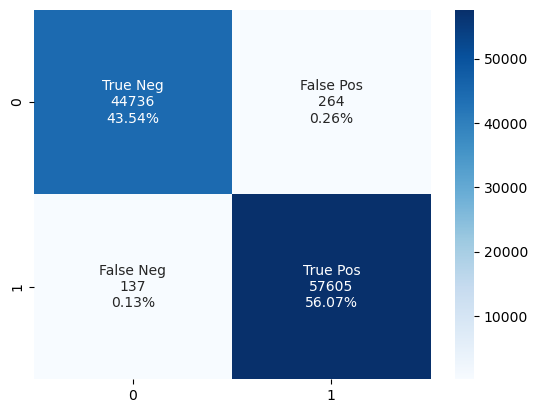

In [28]:
# cf_matrix = np.asarray(results(model_cat,X_train, X_valid, y_train, y_valid))
def plot_confusion(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.clf()
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()

plot_confusion(cf_matrix)


# Model trained on first temporal sequence of data, predict on remaining data

In [29]:
# X = encoded_df.drop(['venueid','link','level1cat','day'],axis=1)

X_train_pos = encoded_df_pos[:int(0.75*len(encoded_df_pos))]
X_valid_pos = encoded_df_pos[int(0.75*len(encoded_df_pos)):]
X_train_neg = encoded_df_neg[:int(0.75*len(encoded_df_neg))]
X_valid_neg = encoded_df_neg[int(0.75*len(encoded_df_neg)):]
X_train_total = X_train_pos.append(X_train_neg)
X_valid_total = X_valid_pos.append(X_valid_neg)

X_train_total = X_train_total.sample(frac=1).reset_index(drop=True)
X_valid_total = X_valid_total.sample(frac=1).reset_index(drop=True)

y_train_total = X_train_total['link']
y_valid_total = X_valid_total['link']
X_train_total = X_train_total.drop(['venueid','link','level1cat','day'],axis=1)
X_valid_total = X_valid_total.drop(['venueid','link','level1cat','day'],axis=1)


In [30]:
X_valid_pos['day'].nunique()

7

Learning rate set to 0.119036
0:	learn: 0.9935233	total: 1.96s	remaining: 32m 35s
100:	learn: 0.9997019	total: 1m 15s	remaining: 11m 7s
200:	learn: 0.9997727	total: 1m 55s	remaining: 7m 37s
300:	learn: 0.9997877	total: 2m 31s	remaining: 5m 52s
400:	learn: 0.9997921	total: 3m 1s	remaining: 4m 31s
500:	learn: 0.9997969	total: 3m 33s	remaining: 3m 32s
600:	learn: 0.9997993	total: 4m 1s	remaining: 2m 40s
700:	learn: 0.9997996	total: 4m 27s	remaining: 1m 53s
800:	learn: 0.9997997	total: 4m 50s	remaining: 1m 12s
900:	learn: 0.9998024	total: 5m 14s	remaining: 34.6s
999:	learn: 0.9998024	total: 5m 37s	remaining: 0us
0.9990912869122802
0.9990818336074855
0.9901890171497537
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     45000
           1       1.00      0.99      0.99     57742

    accuracy                           0.99    102742
   macro avg       0.99      0.99      0.99    102742
weighted avg       0.99      0.99      0.99    102742



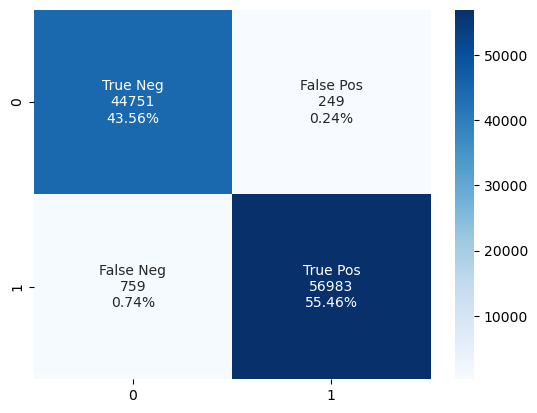

In [31]:
model_cat.fit(X_train_total,y_train_total)
cf_matrix = results(model_cat,X_train_total, X_valid_total, y_train_total, y_valid_total)
plot_confusion(cf_matrix)

# Logreg on entire dataset

In [32]:
#Log reg
model1 = LogisticRegressionCV(Cs = 100,cv=5,penalty = 'l2',
                              solver='saga', 
                              tol=0.01, n_jobs=-1, 
                              random_state = 42).fit(X_train, y_train)
soft_probs = model1.predict_proba(X_valid)
valid_auc = roc_auc_score(y_valid, soft_probs[:,1])
print(valid_auc)
score = model1.score(X_valid, y_valid)
print(score)


0.9820400844369013
0.9434992505499211


0.9820400844369013
0.943119105323094
0.9434992505499211
              precision    recall  f1-score   support

           0       0.96      0.91      0.93     45000
           1       0.93      0.97      0.95     57742

    accuracy                           0.94    102742
   macro avg       0.95      0.94      0.94    102742
weighted avg       0.94      0.94      0.94    102742



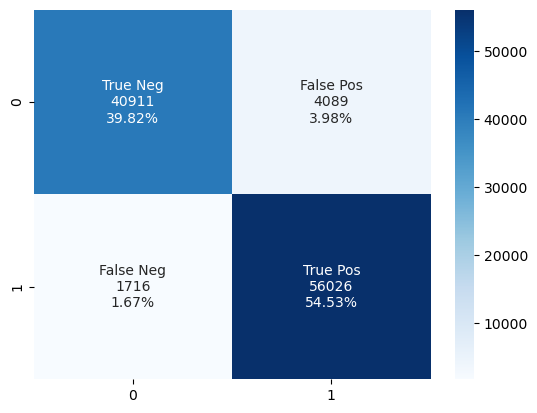

In [33]:
cf_matrix = results(model1,X_train, X_valid, y_train, y_valid)
plot_confusion(cf_matrix)

# Logreg on timeline data

In [34]:
model1 = LogisticRegressionCV(Cs = 100,cv=5,penalty = 'l2',
                              solver='saga', 
                              tol=0.01, n_jobs=-1, 
                              random_state = 42).fit(X_train_total, y_train_total)
soft_probs = model1.predict_proba(X_valid_total)
valid_auc = roc_auc_score(y_valid_total, soft_probs[:,1])
print(valid_auc)
score = model1.score(X_valid_total, y_valid_total)
print(score)

0.98368078887311
0.9467501119308559


0.98368078887311
0.9457016510773044
0.9467501119308559
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     45000
           1       0.94      0.97      0.95     57742

    accuracy                           0.95    102742
   macro avg       0.95      0.94      0.95    102742
weighted avg       0.95      0.95      0.95    102742



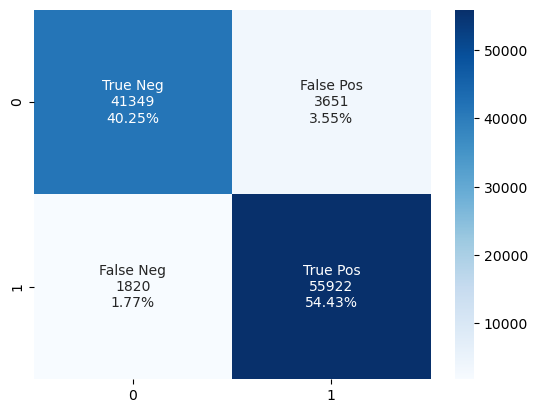

In [35]:
cf_matrix = results(model1,X_train_total, X_valid_total, y_train_total, y_valid_total)
plot_confusion(cf_matrix)

# Extending model to predict Unique Colocations between pairs that never met during training.

In [36]:
# X_train_pos = encoded_df_pos[:int(0.75*len(encoded_df_pos))]
# X_valid_pos = encoded_df_pos[int(0.75*len(encoded_df_pos)):]
# X_train_neg = encoded_df_neg[:int(0.75*len(encoded_df_neg))]
# X_valid_neg = encoded_df_neg[int(0.75*len(encoded_df_neg)):]
# X_train_total = X_train_pos.append(X_train_neg)
# X_valid_total = X_valid_pos.append(X_valid_neg)

# X_train_total = X_train_total.sample(frac=1).reset_index(drop=True)
# X_valid_total = X_valid_total.sample(frac=1).reset_index(drop=True)

# y_train_total = X_train_total['link']
# y_valid_total = X_valid_total['link']
X_unique_valid = pd.merge(X_valid_total,X_train_total, on=['Source_Encoding','Target_Encoding'], how='outer', indicator=True).query("_merge == 'left_only'").reset_index(drop=True)
X_unique_valid.shape

(98933, 29)

In [37]:
print(X_valid_total.shape)
print(X_unique_valid.shape)

(102742, 15)
(98933, 29)


0.9990912869122802
0.9990818336074855
0.9901890171497537
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     45000
           1       1.00      0.99      0.99     57742

    accuracy                           0.99    102742
   macro avg       0.99      0.99      0.99    102742
weighted avg       0.99      0.99      0.99    102742



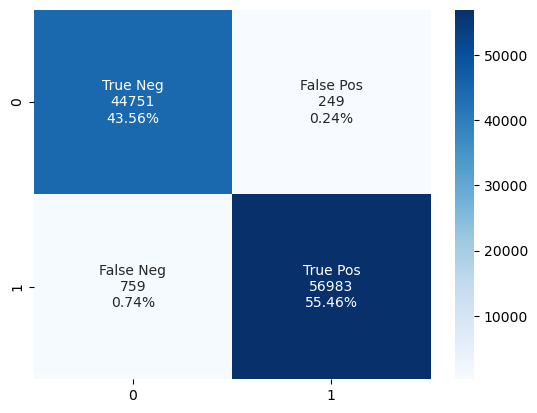

In [38]:
cf_matrix = results(model_cat,X_train_total, X_valid_total, y_train_total, y_valid_total)
plot_confusion(cf_matrix)

# Feature Importance

In [39]:
pd.DataFrame({'feature_importance': model_cat.get_feature_importance(), 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
4,1.982001e+01,Target_Encoding
3,1.890086e+01,Source_Encoding
1,1.874905e+01,time_spent
2,1.648621e+01,visits
0,1.073281e+01,hour
14,3.849734e+00,cat_Travel & Transport
10,3.655042e+00,cat_Outdoors & Recreation
8,3.020852e+00,cat_Food
13,1.790718e+00,cat_Shops & Services
11,1.637033e+00,cat_Professional & Other Places
